In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math
from sklearn.tree import DecisionTreeRegressor
from scipy.special import expit
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from FIS import fis_tree, fis_forest, fis_boosting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from FIS import util
import random
from scipy.special import expit

In [2]:
def simulate_data(nrow, ncol, alphas, betas, p, seed):
  """
  Simulates biased data.
  Inputs:
    * nrow - the number of rows in the output dataset.
    * ncol - the number of non-protected covariates X_i in the output dataset.
    * alphas - numpy array of scalars, where alpha_i controls the effect of
      protected attribute z on covariate X_i through the relationship
      X_i ~ Normal(alpha_i*z, 1).
    * betas - numpy array of scalars, where beta_i controls the effect of
      covariate X_i on the binary outcome y; can be thought of as the regression
      coefficients in the logistic regression scenario.
    * p - the probability of success (aka value 1) for our protected attribute;
      should be less than 0.5.
  Returns:
    * numpy array representing simulated tabular dataset 
  """

  # the following two assertions are to check that the input parameters
  # make sense - we should have one value of alpha and beta for each covariate
  assert ncol == len(alphas)
  assert ncol == len(betas)
  random.seed(seed)
  betas = np.reshape(betas, (len(betas),1))
  # z_i ~ Bernoulli(p)
  z = np.random.binomial(1, p, size=nrow)

  # initialize covariate matrix
  X = np.zeros((nrow, ncol))
  for i in range(ncol):
    random.seed(seed)
    X[:,i] =  alphas[i]*z + np.random.normal(loc = 0 , scale = 0.1, size = nrow)
  random.seed(seed)
  y_prob = X@betas + np.random.normal(loc = 0 , scale = 0.01, size = (nrow,1))
  #y_prob = expit(y_prob)
  y = y_prob
  # combine each element of dataset and we are all done!
  
  
  return X,y,z

In [3]:
alphas = np.array([0,0,0.2,0.2])
betas = np.array([1,1,1,1])
p = 0.2

In [4]:
iterations =3
seed_vec = np.arange(5)
seed_vec2 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
nrow = 500
ncol = 4

In [5]:
dp_mat = np.empty([iterations,ncol])
eo_mat = np.empty([iterations,ncol])
acc_mat = np.empty([iterations,ncol])

for i, s in enumerate(seed_vec):
  X,y,z = simulate_data(nrow,ncol ,alphas, betas, p, s)
  clf = DecisionTreeRegressor(max_depth = 8)
  clf.fit(X,y)
  
  #Our approach
  f_forest = fis_tree(clf,X,y,z,0, regression=True)
  f_forest._calculate_fairness_importance_score()
  
  dp_mat[i] = f_forest._fairness_importance_score_dp_root
  acc_mat[i] = clf.feature_importances_



dp_mean = np.mean(dp_mat, axis = 0)
acc_mean = np.mean(acc_mat, axis = 0)

In [6]:
features = [1,2,3,4]

In [7]:
features

[1, 2, 3, 4]

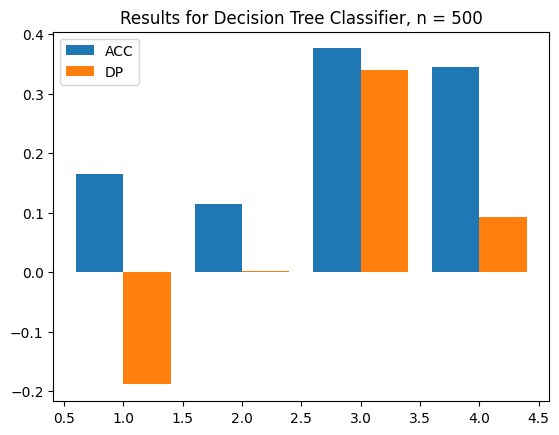

In [8]:
# Make quick bar plots
plt.bar(np.asarray(features) - 0.2, acc_mean,label = 'ACC', width = 0.4)
plt.bar(np.asarray(features) + 0.2, dp_mean,label = 'DP', width = 0.4)
plt.title("Results for Decision Tree Classifier, n = 500")
plt.legend()

In [9]:
dp_mat = np.empty([iterations,ncol])
eo_mat = np.empty([iterations,ncol])
acc_mat = np.empty([iterations,ncol])

for i, s in enumerate(seed_vec):
  X,y,z = simulate_data(nrow,ncol ,alphas, betas, p, s)
  clf = GradientBoostingRegressor(n_estimators=100, max_depth=5, max_features='auto')
  clf.fit(X,y)
  
  #Our approach
  f_forest = fis_boosting(clf,X,y,z,0, regression=True)
  f_forest.calculate_fairness_importance_score()
  
  dp_mat[i] = f_forest._fairness_importance_score_dp
  acc_mat[i] = f_forest.fitted_clf.feature_importances_



dp_mean = np.mean(dp_mat, axis = 0)
acc_mean = np.mean(acc_mat, axis = 0)

d:\Fairness-Importance-Score-FIS-\.venv\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Fairness-Importance-Score-FIS-\.venv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
d:\Fairness-Importance-Score-FIS-\.venv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
d:\Fairness-Importance-Score-FIS-\.venv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behav

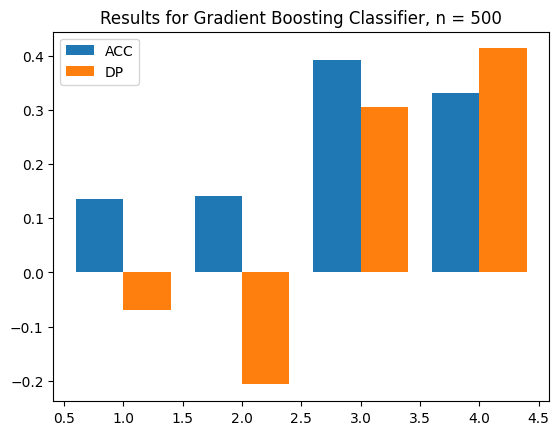

In [10]:
# Make quick bar plots
plt.bar(np.asarray(features) - 0.2, acc_mean,label = 'ACC', width = 0.4)
plt.bar(np.asarray(features) + 0.2, dp_mean,label = 'DP', width = 0.4)
plt.title("Results for Gradient Boosting Classifier, n = 500")
plt.legend()

In [11]:
dp_mat = np.empty([iterations,ncol])
eo_mat = np.empty([iterations,ncol])
acc_mat = np.empty([iterations,ncol])

for i, s in enumerate(seed_vec):
  X,y,z = simulate_data(nrow,ncol ,alphas, betas, p, s)
  clf = RandomForestRegressor(n_estimators=100,n_jobs=-2)
  clf.fit(X,y)
  
  #Our approach
  f_forest = fis_forest(clf,X,y,z,0, regression=True)
  f_forest.calculate_fairness_importance_score()
  
  dp_mat[i] = f_forest._fairness_importance_score_dp_root
  acc_mat[i] = f_forest.clf.feature_importances_



dp_mean = np.mean(dp_mat, axis = 0)
acc_mean = np.mean(acc_mat, axis = 0)

C:\Users\debol\AppData\Local\Temp\ipykernel_40920\1993319281.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  1.2min finished
C:\Users\debol\AppData\Local\Temp\ipykernel_40920\1993319281.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  5.7min finished
C:\Users\debol\AppData\Local\Temp\ipykernel_40920\1993319281.py:8: DataConversionWarning: A column-vector 

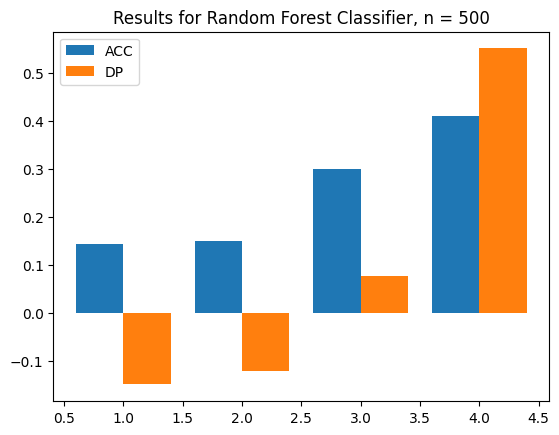

In [12]:
plt.bar(np.asarray(features) - 0.2, acc_mean,label = 'ACC', width = 0.4)
plt.bar(np.asarray(features) + 0.2, dp_mean,label = 'DP', width = 0.4)
plt.title("Results for Random Forest Classifier, n = 500")
plt.legend()